In [1]:
# ============================================
# GAIT CLASSIFICATION
# ============================================

# Setup
import os, zipfile
import pandas as pd
import numpy as np
from google.colab import drive
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from scipy.signal import find_peaks

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import *
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping

plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

CONFIG = {
    'MAX_TIMESTEPS': 150,
    'NUM_FEATURES': 97,
    'TEST_SIZE': 0.2,
    'RANDOM_STATE': 42,
    'BATCH_SIZE': 32,
    'EPOCHS': 100,
    'PATIENCE': 10
}

In [2]:
# Data Loading
drive.mount('/content/drive')
zip_path = '/content/drive/My Drive/ColabNotebooks/humanData/HDA_proj_A2.zip'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall('/content/')
print("✅ Data extracted")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Data extracted


In [3]:
# Create Manifest
def create_manifest(data_dir='/content/'):
    manifest = []
    subject_dirs = sorted([d for d in os.listdir(data_dir)
                          if d.startswith('subject') and os.path.isdir(os.path.join(data_dir, d))])

    for subject_name in subject_dirs:
        subject_id = int(subject_name.replace('subject', ''))
        subject_path = os.path.join(data_dir, subject_name)

        for gait_type in sorted(os.listdir(subject_path)):
            gait_path = os.path.join(subject_path, gait_type)

            for trial_name in sorted(os.listdir(gait_path)):
                trial_id = int(trial_name.replace('trial', ''))
                trial_path = os.path.join(gait_path, trial_name)

                manifest.append({
                    'subject_id': subject_id,
                    'gait_type': gait_type,
                    'trial_id': trial_id,
                    'skeleton_path': os.path.join(trial_path, 'skeleton.csv'),
                    'pressure_path': os.path.join(trial_path, 'pressure.csv')
                })

    return pd.DataFrame(manifest)

df_manifest = create_manifest()
print(f"Found {len(df_manifest)} trials, {df_manifest['gait_type'].nunique()} gait types")

Found 1440 trials, 6 gait types


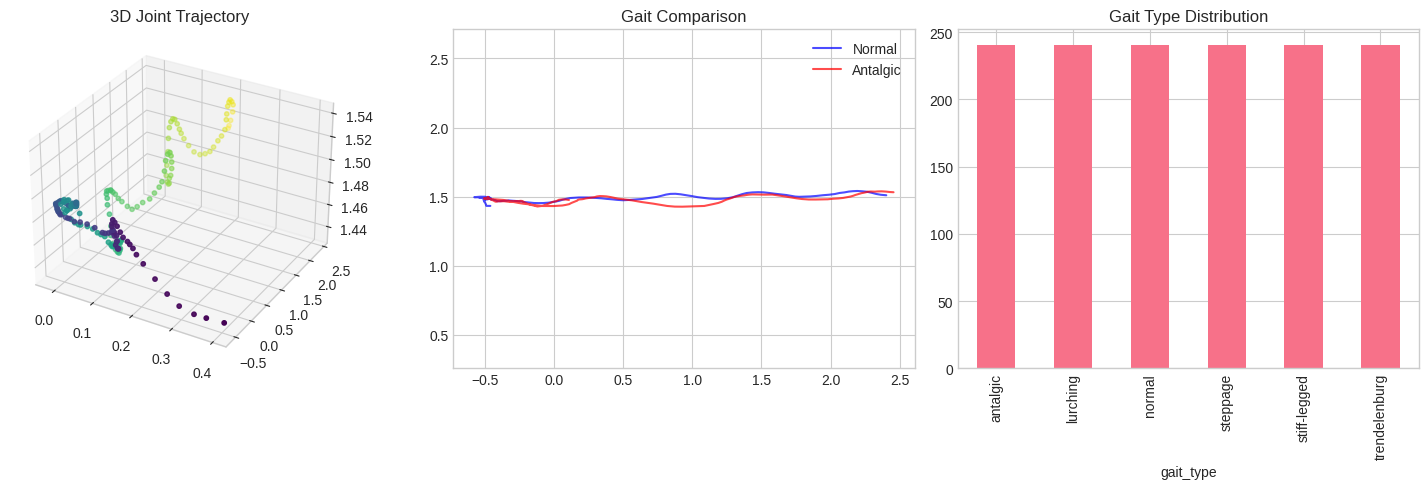

In [4]:
# Quick Visualization
def quick_viz(df_manifest):
    # Sample 3D trajectory
    mask = (df_manifest['subject_id'] == 1) & (df_manifest['gait_type'] == 'normal') & (df_manifest['trial_id'] == 1)
    df_skel = pd.read_csv(df_manifest.loc[mask, 'skeleton_path'].iloc[0])

    fig = plt.figure(figsize=(15, 5))

    # 3D plot
    ax1 = fig.add_subplot(131, projection='3d')
    joint_x, joint_y, joint_z = df_skel.iloc[:, 79], df_skel.iloc[:, 80], df_skel.iloc[:, 81]
    ax1.scatter(joint_x, joint_y, joint_z, c=range(len(joint_x)), cmap='viridis', s=10)
    ax1.set_title('3D Joint Trajectory')

    # Comparison plot
    ax2 = fig.add_subplot(132)
    for gait, color in zip(['normal', 'antalgic'], ['blue', 'red']):
        mask = (df_manifest['subject_id'] == 1) & (df_manifest['gait_type'] == gait) & (df_manifest['trial_id'] == 1)
        if mask.sum() > 0:
            df = pd.read_csv(df_manifest.loc[mask, 'skeleton_path'].iloc[0])
            ax2.plot(df.iloc[:, 80], df.iloc[:, 81], label=gait.title(), color=color, alpha=0.7)
    ax2.set_title('Gait Comparison')
    ax2.legend()
    ax2.axis('equal')

    # Distribution
    ax3 = fig.add_subplot(133)
    df_manifest['gait_type'].value_counts().plot(kind='bar', ax=ax3)
    ax3.set_title('Gait Type Distribution')

    plt.tight_layout()
    plt.show()

quick_viz(df_manifest)

In [5]:
# Data Preprocessing
def load_and_preprocess(df_manifest, config):
    sequences, labels = [], []

    for _, row in df_manifest.iterrows():
        df_skel = pd.read_csv(row['skeleton_path'])
        df_skel.replace([np.inf, -np.inf], 0, inplace=True)
        df_skel.fillna(0, inplace=True)
        sequences.append(df_skel.iloc[:, 1:].values)
        labels.append(row['gait_type'])

    # Encode labels
    label_encoder = LabelEncoder()
    labels_encoded = label_encoder.fit_transform(labels)
    labels_onehot = to_categorical(labels_encoded)

    # Pad sequences
    sequences_padded = pad_sequences(sequences, maxlen=config['MAX_TIMESTEPS'],
                                    dtype='float32', padding='post', truncating='post')

    # Split
    X_train, X_test, y_train, y_test = train_test_split(
        sequences_padded, labels_onehot, test_size=config['TEST_SIZE'],
        random_state=config['RANDOM_STATE'], stratify=labels_onehot)

    # Normalize
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train.reshape(-1, config['NUM_FEATURES'])).reshape(X_train.shape)
    X_test = scaler.transform(X_test.reshape(-1, config['NUM_FEATURES'])).reshape(X_test.shape)

    print(f"Train: {X_train.shape}, Test: {X_test.shape}, Classes: {len(label_encoder.classes_)}")
    return X_train, X_test, y_train, y_test, label_encoder, sequences

# Load data
X_train, X_test, y_train, y_test, label_encoder, sequences = load_and_preprocess(df_manifest, CONFIG)
num_classes = y_train.shape[1]

Train: (1152, 150, 97), Test: (288, 150, 97), Classes: 6


In [6]:
# All Model Definitions
class Models:
    @staticmethod
    def baseline(input_shape, num_classes):
        return Sequential([
            Masking(mask_value=0., input_shape=input_shape),
            LSTM(128),
            Dropout(0.5),
            Dense(64, activation='relu'),
            Dropout(0.5),
            Dense(num_classes, activation='softmax')
        ])

    @staticmethod
    def dual_lstm(input_shape, num_classes):
        return Sequential([
            Masking(mask_value=0., input_shape=input_shape),
            LSTM(128, return_sequences=True),
            Dropout(0.3),
            LSTM(64),
            Dropout(0.5),
            Dense(64, activation='relu'),
            Dropout(0.5),
            Dense(num_classes, activation='softmax')
        ])

    @staticmethod
    def light(input_shape, num_classes):
        return Sequential([
            Masking(mask_value=0., input_shape=input_shape),
            LSTM(64),
            Dropout(0.4),
            Dense(32, activation='relu'),
            Dropout(0.4),
            Dense(num_classes, activation='softmax')
        ])

    @staticmethod
    def deep_dense(input_shape, num_classes):
        return Sequential([
            Masking(mask_value=0., input_shape=input_shape),
            LSTM(128),
            Dropout(0.5),
            Dense(128, activation='relu'),
            Dropout(0.4),
            Dense(64, activation='relu'),
            Dropout(0.3),
            Dense(32, activation='relu'),
            Dense(num_classes, activation='softmax')
        ])

    @staticmethod
    def bilstm(input_shape, num_classes):
        return Sequential([
            Masking(mask_value=0., input_shape=input_shape),
            Bidirectional(LSTM(64, return_sequences=True)),
            Dropout(0.4),
            Bidirectional(LSTM(32)),
            Dropout(0.4),
            Dense(64, activation='relu'),
            Dropout(0.3),
            Dense(num_classes, activation='softmax')
        ])

    @staticmethod
    def cnn_lstm(input_shape, num_classes):
        return Sequential([
            Masking(mask_value=0., input_shape=input_shape),
            Conv1D(64, 3, activation='relu', padding='same'),
            Conv1D(128, 3, activation='relu', padding='same'),
            MaxPooling1D(2),
            Dropout(0.3),
            LSTM(100, return_sequences=True),
            LSTM(50),
            Dropout(0.5),
            Dense(64, activation='relu'),
            Dense(num_classes, activation='softmax')
        ])

    @staticmethod
    def gru(input_shape, num_classes):
        return Sequential([
            Masking(mask_value=0., input_shape=input_shape),
            GRU(128, return_sequences=True),
            Dropout(0.3),
            GRU(64),
            Dropout(0.4),
            Dense(64, activation='relu'),
            Dropout(0.4),
            Dense(num_classes, activation='softmax')
        ])

    @staticmethod
    def attention(input_shape, num_classes):
        inputs = Input(shape=input_shape)
        x = Masking(mask_value=0.)(inputs)
        x = LSTM(128, return_sequences=True)(x)
        x = Dropout(0.3)(x)
        x = MultiHeadAttention(num_heads=4, key_dim=32)(x, x)
        x = GlobalAveragePooling1D()(x)
        x = Dense(64, activation='relu')(x)
        x = Dropout(0.5)(x)
        outputs = Dense(num_classes, activation='softmax')(x)
        return Model(inputs, outputs)

In [7]:
# Training Pipeline
def train_model(model_func, model_name, X_train, y_train, X_test, y_test, config):
    print(f"\n{'='*50}\nTraining: {model_name}")

    # Build and compile
    model = model_func((config['MAX_TIMESTEPS'], config['NUM_FEATURES']), y_train.shape[1])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # Train
    early_stop = EarlyStopping(monitor='val_loss', patience=config['PATIENCE'], restore_best_weights=True)
    history = model.fit(X_train, y_train, epochs=config['EPOCHS'], batch_size=config['BATCH_SIZE'],
                       validation_split=0.2, callbacks=[early_stop], verbose=1)

    # Evaluate
    test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
    print(f"Test Accuracy: {test_acc:.4f}")

    return {
        'model': model,
        'history': history,
        'test_loss': test_loss,
        'test_accuracy': test_acc,
        'epochs': len(history.history['loss'])
    }

In [8]:
# Train All Models
models_to_test = {
    'baseline': Models.baseline,
    'dual_lstm': Models.dual_lstm,
    'light': Models.light,
    'deep_dense': Models.deep_dense,
    'bilstm': Models.bilstm,
    'cnn_lstm': Models.cnn_lstm,
    'gru': Models.gru,
    'attention': Models.attention
}

results = {}
for name, func in models_to_test.items():
    results[name] = train_model(func, name, X_train, y_train, X_test, y_test, CONFIG)


Training: baseline


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/masking.py:48: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 6s 39ms/step - accuracy: 0.1711 - loss: 1.9402 - val_accuracy: 0.3030 - val_loss: 1.7192
Epoch 2/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.2716 - loss: 1.7316 - val_accuracy: 0.4242 - val_loss: 1.6017
Epoch 3/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.3402 - loss: 1.6303 - val_accuracy: 0.4935 - val_loss: 1.4637
Epoch 4/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.3862 - loss: 1.4670 - val_accuracy: 0.6104 - val_loss: 1.1967
Epoch 5/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5657 - loss: 1.1964 - val_accuracy: 0.5628 - val_loss: 1.1256
Epoch 6/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.4744 - loss: 1.2939 - val_accuracy: 0.6190 - val_loss: 1.0152
Epoch 7/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.4978 - loss: 1.2880 - val_accuracy: 0.5281 - val_loss: 1.2691
Epoch 8/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.4312 - loss: 1.3590 - val_accuracy: 0.

/usr/local/lib/python3.12/dist-packages/keras/src/layers/layer.py:965: UserWarning: Layer 'conv1d' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - accuracy: 0.2117 - loss: 1.7656 - val_accuracy: 0.4502 - val_loss: 1.5135
Epoch 2/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.4226 - loss: 1.4621 - val_accuracy: 0.4545 - val_loss: 1.1686
Epoch 3/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.4969 - loss: 1.1617 - val_accuracy: 0.6580 - val_loss: 0.8763
Epoch 4/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5927 - loss: 1.0230 - val_accuracy: 0.7013 - val_loss: 0.8858
Epoch 5/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.6504 - loss: 0.8562 - val_accuracy: 0.7100 - val_loss: 0.6625
Epoch 6/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.7235 - loss: 0.7185 - val_accuracy: 0.7273 - val_loss: 0.6983
Epoch 7/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.7550 - loss: 0.6825 - val_accuracy: 0.7662 - val_loss: 0.6418
Epoch 8/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.7738 - loss: 0.6307 - val_accuracy: 0.7706 - val_l


RESULTS COMPARISON
     Model  Accuracy     Loss  Epochs
 attention  0.913194 0.313769      26
       gru  0.909722 0.422613      42
deep_dense  0.878472 0.382413      57
  cnn_lstm  0.875000 0.357649      31
  baseline  0.871528 0.398197      44
 dual_lstm  0.857639 0.447724      40
     light  0.854167 0.420528      36
    bilstm  0.833333 0.456920      28


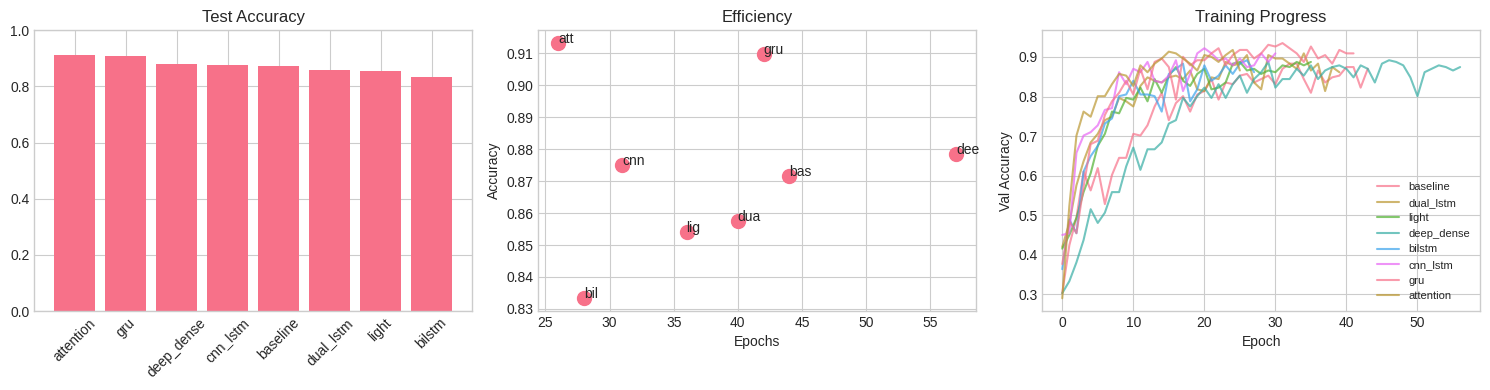

In [9]:
# Compare Results
df_results = pd.DataFrame([{
    'Model': name,
    'Accuracy': r['test_accuracy'],
    'Loss': r['test_loss'],
    'Epochs': r['epochs']
} for name, r in results.items()]).sort_values('Accuracy', ascending=False)

print("\n" + "="*50)
print("RESULTS COMPARISON")
print("="*50)
print(df_results.to_string(index=False))

# Visualization
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Accuracy comparison
axes[0].bar(df_results['Model'], df_results['Accuracy'])
axes[0].set_title('Test Accuracy')
axes[0].set_ylim([0, 1])
axes[0].tick_params(axis='x', rotation=45)

# Efficiency plot
axes[1].scatter(df_results['Epochs'], df_results['Accuracy'], s=100)
for _, row in df_results.iterrows():
    axes[1].annotate(row['Model'][:3], (row['Epochs'], row['Accuracy']))
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Efficiency')

# Training curves
for name, r in results.items():
    axes[2].plot(r['history'].history['val_accuracy'], label=name, alpha=0.7)
axes[2].set_xlabel('Epoch')
axes[2].set_ylabel('Val Accuracy')
axes[2].set_title('Training Progress')
axes[2].legend(loc='best', fontsize=8)

plt.tight_layout()
plt.show()


🏆 Best Model: attention (0.9132)

Classification Report:
               precision    recall  f1-score   support

     antalgic       0.88      0.90      0.89        48
     lurching       0.90      0.94      0.92        48
       normal       0.88      0.92      0.90        48
     steppage       0.91      0.90      0.91        48
 stiff-legged       0.96      0.92      0.94        48
trendelenburg       0.96      0.92      0.94        48

     accuracy                           0.91       288
    macro avg       0.91      0.91      0.91       288
 weighted avg       0.91      0.91      0.91       288



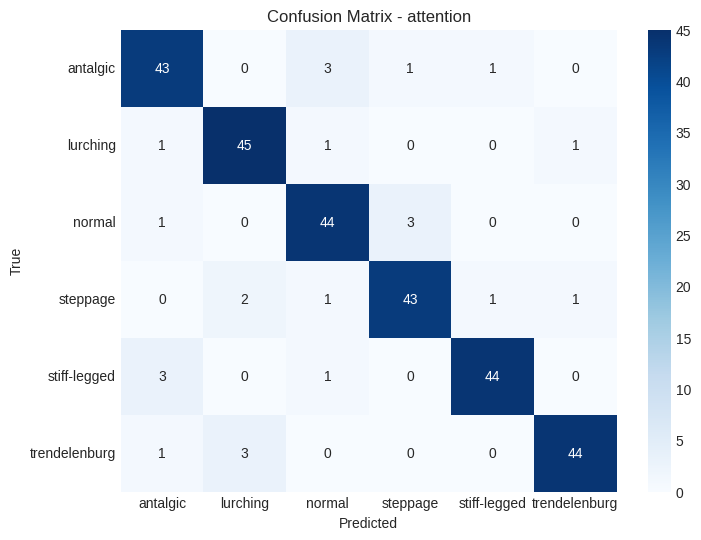

In [10]:
# Best Model Analysis
best_model_name = df_results.iloc[0]['Model']
best_results = results[best_model_name]

print(f"\n🏆 Best Model: {best_model_name} ({df_results.iloc[0]['Accuracy']:.4f})")

# Predictions
y_pred = np.argmax(best_results['model'].predict(X_test, verbose=0), axis=1)
y_true = np.argmax(y_test, axis=1)

# Classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=label_encoder.classes_))

# Confusion matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title(f'Confusion Matrix - {best_model_name}')
plt.ylabel('True')
plt.xlabel('Predicted')
plt.show()